## Stability Region of Integrators

### Oscar Reula

##### [Click here to download this notebook](/weave/lab02/stability_region.ipynb)


The stability region is the region in the complex plane where the amplification factor of the integrator is smaller than one when solving for $u_t = \lambda u$. To do that we solve the system for the vector $(u_r, u_i)$. One can also use complex algebra.

$$
\begin{aligned}
   \frac{d}{dt} \left(
        \begin{array}{c}
        u_r \\
        u_i
        \end{array}
    \right) 
    &=&
    \left(
        \begin{array}{cc}
        \lambda_r & -\lambda_i \\
        \lambda_i & \lambda_r
        \end{array}
    \right)
    \left(
        \begin{array}{c}
        u_r \\
        u_i
        \end{array}
    \right) 
\end{aligned}
$$
When discretizating in time we obtain an algorithm for the discrete approximation:
$$
\begin{aligned}
    \left(
        \begin{array}{c}
        v^{n+1}_r \\
        v^{n+1}_i
        \end{array}
    \right) 
    &=&
    \left(
        \begin{array}{c}
        v^{n}_r \\
        v^{n}_i
        \end{array}
    \right) 
    +
    \left(
        \begin{array}{cc}
        A^1{}_1 & A^1{}_2 \\
        A^2{}_1 & A^2{}_2
        \end{array}
    \right)
    \left(
        \begin{array}{c}
        v^{n}_r \\
        v^{n}_i
        \end{array}
    \right) 
    =\left(
        \begin{array}{cc}
        F^1{}_1 & F^1{}_2 \\
        F^2{}_1 & F^2{}_2
        \end{array}
    \right)
    \left(
        \begin{array}{c}
        v^{n}_r \\
        v^{n}_i
        \end{array}
    \right) 
\end{aligned}
$$
Where 
$$
\begin{aligned}
    \left(
        \begin{array}{c}
        F^1{}_1 & F^1{}_2 \\
        F^2{}_1 & F^2{}_2
        \end{array}
    \right) 
    &=&
    \left(
        \begin{array}{c}
        F((1,0)) &
        F((0.1))
        \end{array}
    \right) 
\end{aligned}
$$
And $F(u)$ is one step (with $dt=1$) of the method used. 

The amplification factor is then the norm of the $F$ matrix. which in turn
is given by the largest eigenvalue (in absolute value). 

The eigenvalues are given by:
$$
\begin{equation}
\sigma_{\pm} = \frac{1}{2}(F^1{}_1 + F^2{}_2 \pm \sqrt{(F^1{}_1 - F^2{}_2)^2 + 4 F^1{}_2 F^2{}_1})
\end{equation}
$$

Since the coefficients are all real then if the discriminat is positive the roots are real and so we take the largest in absolute value.

On the other hand, if it is negative then the absolute value squared is given by,
the determinant of $F$ (the product of eigenvalues, since they are conjugated.

For instance, for the Euler explicit method, namely (dt=1)

\begin{equation}
v^{n+1} = v^n + \lambda v^n = (1+\lambda) v^n
\end{equation}

The matrix is:
$$
    \left(
        \begin{array}{c}
        1 + \lambda_r & -i \lambda_i \\
        \lambda_i & 1 +\lambda_r
        \end{array}
    \right) 
$$

$$
\sigma_{\pm} = 1 + \lambda_r \pm i \lambda_i
$$

Therefore, 

$$
\begin{aligned}
|\sigma_{\pm}|^2 &=& \sigma_+ \sigma_- \\
                &=&  (-1 - \lambda_r)^2 + \lambda_i^2 \\
                &=& | (-1,0) - (\lambda_r, \lambda_i)|^2
\end{aligned}
$$
Thus the stability region is the unit circle around the point $(-1,0)$ of the complex plane.

In [ ]:
using Pkg
Pkg.activate("../../PDE2025")
using OrdinaryDiffEq
#using ODE
#using Sundials
#using LSODA

After calling the Ordinary Differential Equations Package we define the function to integrate, in our case it is just $u_t = \lambda u$

In [2]:
function f(du,u,par,t)
    λ_r, λ_i = par
    du[1] = λ_r * u[1] - λ_i * u[2]
    du[2] = λ_i * u[1] + λ_r * u[2]
end 

f (generic function with 1 method)

Now we define an index function which returns 1 if the $\lambda$ value is stable, otherwise returns 0.

In [3]:
function stability_index(par, method)
    # first the two initial values needed for computing the matrix F
    u_p = [1.; 0.]
    u_m = [0.; 1.]

    # for time we put T = dt = 1 so that there will be just one step
    T=1. 
    tspan = (0., T)
    # we put some values for the errors, probably they can be taken away, 
    # but in some cases they can go to defaults and create problems.
    reltol = 2.
    abstol = 2.
    # we create the two problems (different initial conditions)
    prob_p = ODEProblem(f,u_p,tspan,par);
    prob_m = ODEProblem(f,u_m,tspan,par);
    
    # and solve them. Notice that we take adaptive = false, so that the methods will not change anything
    v_p = solve(prob_p,method, reltol=reltol, abstol=abstol, adaptive=false, dtmin=1., dt=1., save_everystep=false);
    v_m = solve(prob_m,method, reltol=reltol, abstol=abstol, adaptive=false, dtmin=1., dt=1., save_everystep=false);
    
    #We take the values at T=1.
    F_p = v_p.u[end]
    F_m = v_m.u[end]
    
    # and build the F matrix
    F11 = F_p[1]
    F12 = F_m[1]
    F21 = F_p[2]
    F22 = F_m[2]
    
    # now we can compute the maximum, that is the spectral radius.
    
    if (F11-F22)^2 + 4. * (F12 * F21) >= 0.
        σ_p = ((F11 + F22) + sqrt((F11-F22)^2 + 4. * (F12 * F21))) / 2.
        σ_m = ((F11 + F22) - sqrt((F11-F22)^2 + 4. * (F12 * F21))) / 2.
        max = maximum([abs(σ_p); abs(σ_m)])
    else
        max = abs(F11 * F22 - F12 * F21)
    end
    
    if max > 1. return 0.
        else return 1.
    end
end

stability_index (generic function with 1 method)

A list of possible methods is here: https://diffeq.sciml.ai/stable/solvers/ode_solve/

In [4]:
#method = Tsit5()
methods = (Euler(), Heun(), RK4(), Tsit5(), SSPRK33(), SSPRK54())
#method = Heun()
#method = RK4()


#stability_index((-2.,0.0), method)

(Euler(), Heun{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false)), RK4{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false)), Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false)), SSPRK33{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false)), SSPRK54{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, stati

In [5]:
using Plots

#Plots.PlotlyBackend()
#using ImageMagick (sometimes needed for animations)
#using PyPlot
#ioff() # Interactive plotting OFF, necessary for inline plotting in IJulia

In [6]:
default(size=(600,900), fc=:heat)
x = -5.5:0.02:0.5
y = -5:0.01:5
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x));

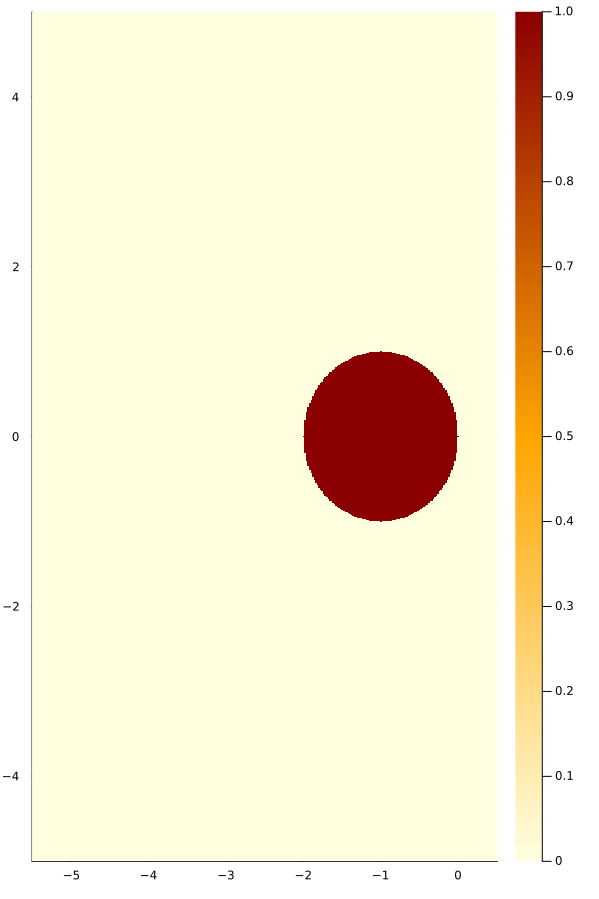

In [7]:
z = heatmap(x,y,(x,y)->stability_index((x,y),Euler()))

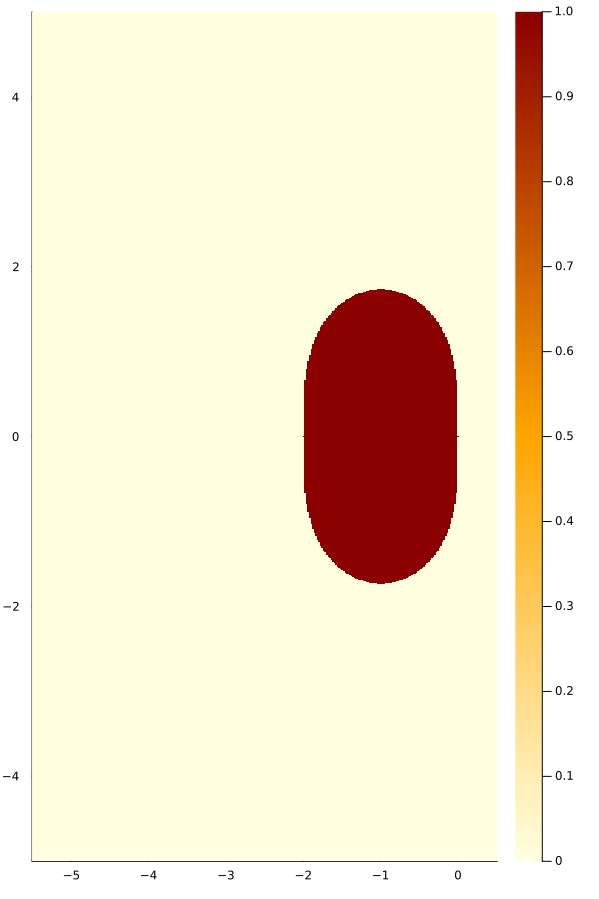

In [8]:
z = heatmap(x,y,(x,y)->stability_index((x,y),Heun()))

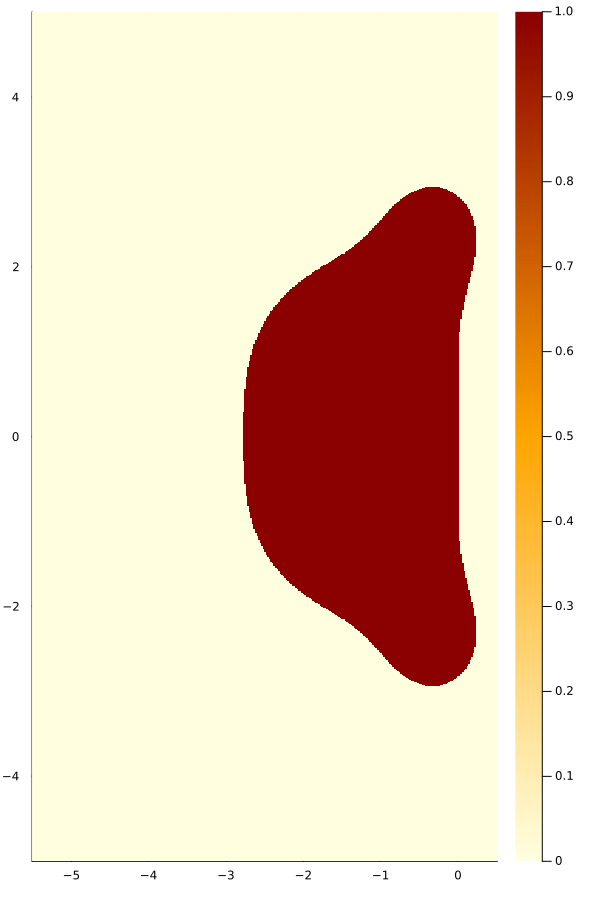

In [9]:
z = heatmap(x,y,(x,y)->stability_index((x,y),RK4()))

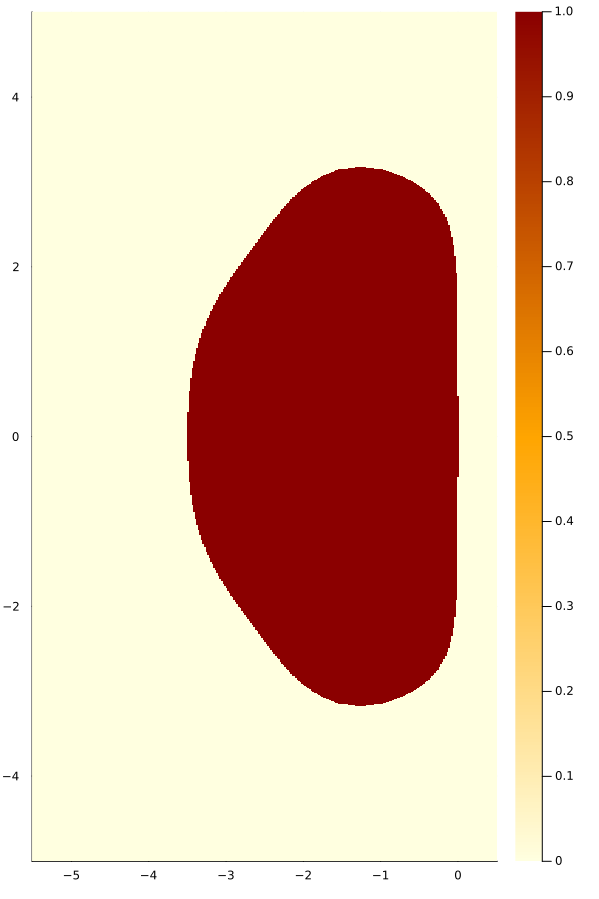

In [10]:
z = heatmap(x,y,(x,y)->stability_index((x,y),Tsit5()))

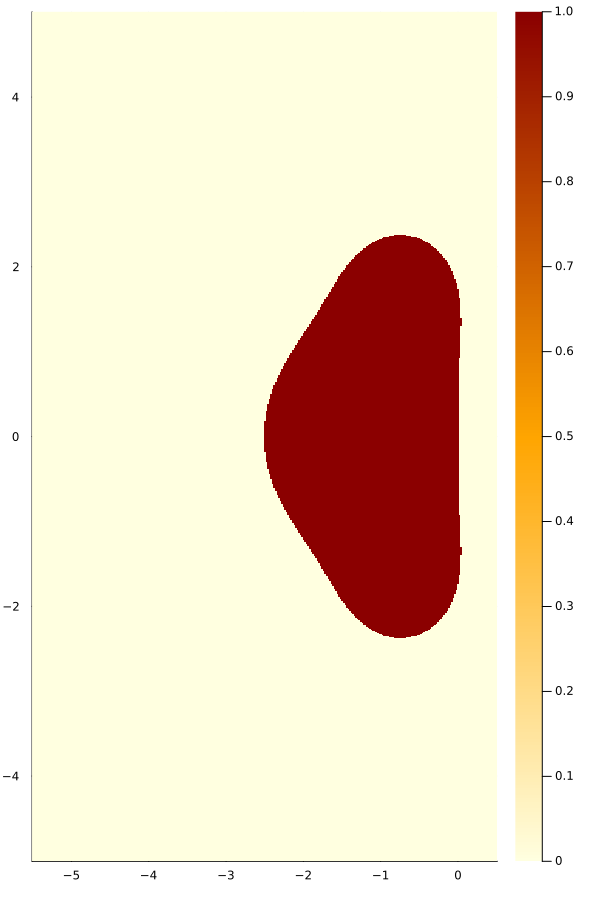

In [11]:
z = heatmap(x,y,(x,y)->stability_index((x,y),SSPRK33()))

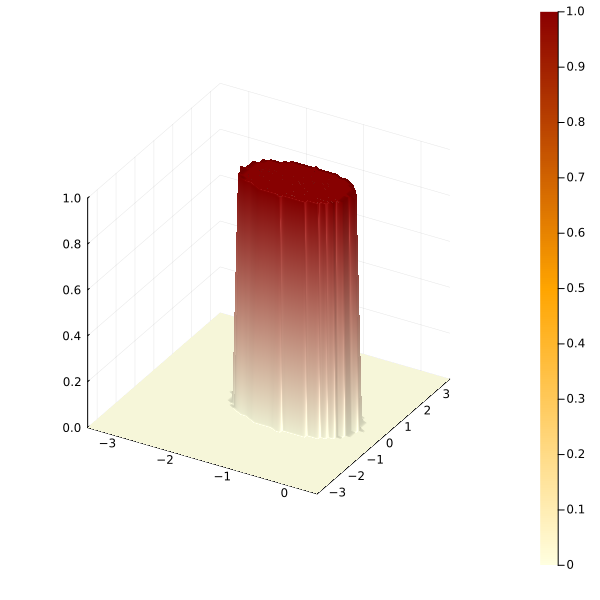

In [12]:
default(size=(600,600), fc=:heat)
x, y = -3.5:0.1:0.5, -3.5:0.1:3.5
z = Surface((x,y)->stability_index((x,y),Euler()), x, y)
surface(x,y,z, linealpha = 0.3)
#stability_index((1,2),Euler())